12 files found:
  - 112288.lvm
  - 112289.lvm
  - 112295.lvm
  - 112296.lvm
  - 112297.lvm
  - 112298.lvm
  - 112299.lvm
  - 112300.lvm
  - 112301.lvm
  - 112302.lvm
  - 112303.lvm
  - 112305.lvm
Loading 112288.lvm...
Loading 112289.lvm...
Loading 112295.lvm...
Loading 112296.lvm...
Loading 112297.lvm...
Loading 112298.lvm...
Loading 112299.lvm...
Loading 112300.lvm...
Loading 112301.lvm...
Loading 112302.lvm...
Loading 112303.lvm...
Loading 112305.lvm...

Heating event summary:
  file   TC            TC_Description  trigger_t  t1_min  t1_max   t2_t  deltaT1  deltaT2  deltaT
112288 TC14 NB Calorimeter 0 (center)     10.800   9.800  10.800 10.800   26.299   29.601   3.302
112288 TC15  NB Calorimeter 1 (lower)     10.800   9.800  10.800 10.800   25.870   27.745   1.875
112288 TC16  NB Calorimeter 2 (right)     10.800   9.800  10.800 10.800   26.116   28.056   1.941
112288 TC17  NB Calorimeter 3 (upper)     10.800   9.800  10.800 10.800   25.809   27.729   1.920
112288 TC18   NB Calorimet

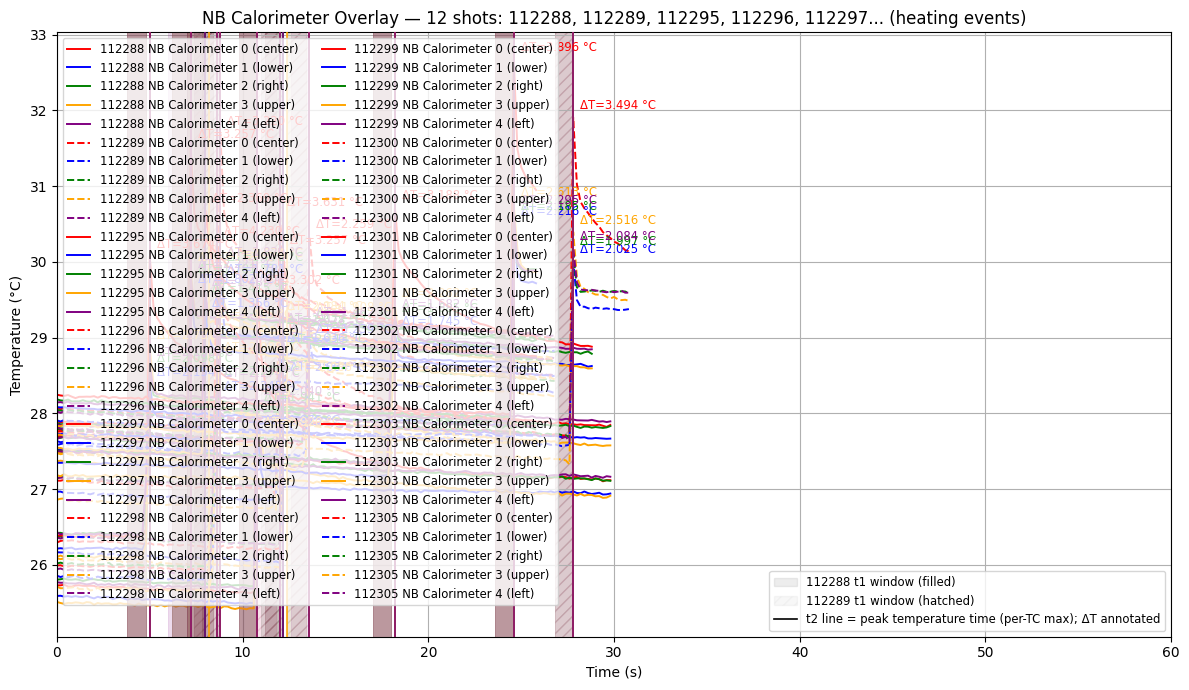


Per-shot deltaT DataFrame (in-memory):
  file  TC14  TC15  TC16  TC17  TC18
112288 3.302 1.875 1.941 1.920 2.040
112289 3.257 2.004 2.113 2.086 2.230
112295 3.674 2.154 2.098 2.731 2.130
112296 3.631 1.636 1.678 2.084 2.037
112297 3.257 1.802 1.781 2.178 2.221
112298 2.259 1.239 1.447 1.908 1.462
112299 3.188 1.745 1.685 2.262 1.682
112300 3.220 1.781 1.772 2.074 1.829
112301 2.369 1.356 1.415 1.415 1.489
112302 3.494 2.025 1.997 2.516 2.084
112303 3.896 2.216 2.185 2.613 2.295
112305 4.230 2.345 2.289 2.988 2.274

MEAN COPPER CALORIMETER HEATING PER SHOT

  Shot  Mean ΔT (°C)  Std Dev (°C)  N TCs
112288         2.215         0.546      5
112289         2.338         0.465      5
112295         2.557         0.606      5
112296         2.213         0.732      5
112297         2.248         0.537      5
112298         1.663         0.370      5
112299         2.112         0.580      5
112300         2.135         0.554      5
112301         1.609         0.382      5
112302         2

In [33]:
## Delta T Analysis for Copper Calorimeter

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from pathlib import Path

# where the thermocouple data lives
BASE_FOLDER = Path("/p/ltxdata/thermocouple/LTXB")

# put shot numbers here, leave empty to load all files
shotlist = [
    
    112288,112289,112295,112296,
    112297,112298,112299,112300,112301,112302,
    112303,112305
    
    
]

# plot window settings
tmin, tmax = 0, 60
ymin, ymax = None, None  # set to None for auto-scale

# thermocouple labels (TC14-18 are on the beam calorimeter)
TC_LABELS = {
    "TC14": "NB Calorimeter 0 (center)",
    "TC15": "NB Calorimeter 1 (lower)",
    "TC16": "NB Calorimeter 2 (right)",
    "TC17": "NB Calorimeter 3 (upper)",
    "TC18": "NB Calorimeter 4 (left)",
}

# plot colors for each TC
TC_COLORS = {
    "TC14": "red",
    "TC15": "blue",
    "TC16": "green",
    "TC17": "orange",
    "TC18": "purple",
}

def find_data_start(path: Path) -> int:
    """LVM files have a header, need to find where the actual data starts"""
    end_idx = -1
    with open(path, "r", errors="replace") as f:
        for i, line in enumerate(f):
            if line.strip() == "***End_of_Header***":
                end_idx = i
    if end_idx == -1:
        raise RuntimeError("***End_of_Header*** not found in file.")
    return end_idx + 1

def load_lvm(path: Path):
    """Load LVM file and extract time + temperature data"""
    start_row = find_data_start(path)
    df = pd.read_csv(path, sep="\t", skiprows=start_row)
    df.columns = [c.strip().replace(" ", "_") for c in df.columns]

    if "X_Value" not in df.columns:
        raise RuntimeError(f"X_Value column not found in {path}")

    time = pd.to_numeric(df["X_Value"], errors="coerce")

    # grab all the TC temperature columns
    tc_data = {}
    for num, label in TC_LABELS.items():
        col = f"Temperature_{int(num.replace('TC',''))}"
        if col in df.columns:
            tc_data[num] = pd.to_numeric(df[col], errors="coerce")

    return time, tc_data

def find_lvm_file(folder: Path, shot_spec) -> Path | None:
    """Try to find the LVM file for a given shot (handles different formats)"""
    
    shot_str = str(shot_spec).strip()
    
    # check if it's already a full path
    candidate = Path(shot_str)
    if candidate.is_file():
        return candidate
    
    stem = Path(shot_str).stem
    
    # get all lvm files
    lvm_files = [p for p in folder.iterdir() if p.is_file() and p.suffix.lower() == '.lvm']
    
    # try exact match first
    for p in lvm_files:
        if p.stem == stem:
            return p
    
    for p in lvm_files:
        if p.name == shot_str:
            return p
    
    # try prefix match (some files have extra stuff after shot number)
    for p in lvm_files:
        if p.name.startswith(stem):
            return p
    
    return None


# load the files
data_folder = BASE_FOLDER
if shotlist:
    # load specific shots from the list
    lvm_files = []
    for shot_spec in shotlist:
        found = find_lvm_file(data_folder, shot_spec)
        if found:
            lvm_files.append(found)
        else:
            print(f"shot '{shot_spec}' not found in {data_folder}")
    
    if not lvm_files:
        raise RuntimeError(f"no shots found in the folder ->{data_folder}")
else:
    # load everything in the folder
    lvm_files = sorted(data_folder.glob("*.lvm"))
    if not lvm_files:
        raise RuntimeError(f"No .lvm files found in {data_folder}")

print(f"{len(lvm_files)} files found:")
for f in lvm_files:
    print(f"  - {f.name}")

# actually load all the data
all_file_data = {}
for lvm_file in lvm_files:
    try:
        print(f"Loading {lvm_file.name}...")
        time, data = load_lvm(lvm_file)
        all_file_data[lvm_file.stem] = (time, data)
    except Exception as e:
        print(f"Error loading {lvm_file}: {e}")


def detect_heating_event(time: pd.Series, temp: pd.Series, rate_threshold: float = 0.2):
    """Find when the temperature starts rising quickly (heating event)
    
    Returns a dict with trigger time, baseline temp, peak temp, and deltaT
    """
    
    time = pd.to_numeric(time, errors='coerce')
    temp = pd.to_numeric(temp, errors='coerce')

    # calculate dT/dt
    dtemp = temp.diff()
    dt = time.diff()
    with np.errstate(divide='ignore', invalid='ignore'):
        rate = dtemp / dt

    # find where rate exceeds threshold
    cond = rate.abs() > rate_threshold
    if not cond.any():
        return {'trigger_t': None, 't1_min': None, 't1_max': None,
                't2_t': None, 'deltaT1': np.nan, 'deltaT2': np.nan, 'deltaT': np.nan}

    trigger_idx = cond[cond].index[0]
    trigger_t = float(time.iloc[trigger_idx])

    # get baseline temp from 1 second before trigger
    t1_min = trigger_t - 1.0
    t1_max = trigger_t

    mask_t1 = (time >= t1_min) & (time <= t1_max)
    deltaT1 = float(temp[mask_t1].mean()) if mask_t1.any() else np.nan

    # find peak temperature
    try:
        idx_t2 = temp.idxmax()
        t2_t = float(time.loc[idx_t2])
        deltaT2 = float(temp.loc[idx_t2])
    except Exception:
        t2_t = None
        deltaT2 = np.nan

    deltaT = np.nan if np.isnan(deltaT1) or np.isnan(deltaT2) else float(deltaT2 - deltaT1)

    return {'trigger_t': trigger_t, 't1_min': t1_min, 't1_max': t1_max,
            't2_t': t2_t, 'deltaT1': deltaT1, 'deltaT2': deltaT2, 'deltaT': deltaT}


def compute_global_trigger(time: pd.Series, data: dict) -> float | None:
    """Alternative method: use all TCs together to find heating start
    
    Sometimes individual TCs don't trigger well, so this sums up the
    heating rates from all TCs to find when beam turns on
    """
    if not data:
        return None
    try:
        df = pd.DataFrame({k: pd.to_numeric(v, errors='coerce') for k, v in data.items()})
        t = pd.to_numeric(time, errors='coerce')
        
        # get derivatives for each TC
        dt = t.diff()
        with np.errstate(divide='ignore', invalid='ignore'):
            rates = df.diff().divide(dt, axis=0)
        
        # only keep positive rates (heating)
        pos = rates.clip(lower=0)
        agg = pos.sum(axis=1)
        idx = agg.idxmax()
        if pd.isna(idx):
            return None
        return float(t.loc[idx])
    except Exception:
        return None


# create the plot
plt.figure(figsize=(12, 7))
ax = plt.gca()

rows = []
for idx, (file_label, (time, data)) in enumerate(all_file_data.items()):
    for num, pretty in TC_LABELS.items():
        color = TC_COLORS.get(num, 'black')
        if num not in data:
            rows.append({'file': file_label, 'TC': num, 'trigger_t': None,
                         't1_min': None, 't1_max': None, 't2_t': None,
                         'deltaT1': np.nan, 'deltaT2': np.nan, 'deltaT': np.nan})
            continue

        temp = data[num]
        # try to detect heating with per-TC method
        res = detect_heating_event(time, temp, rate_threshold=0.5)
        
        # if that didn't work, use global trigger as fallback
        if res.get('trigger_t') is None:
            gtrig = compute_global_trigger(time, data)
            if gtrig is not None:
                # recalculate deltaT using global trigger time
                t_arr = pd.to_numeric(time, errors='coerce')
                temp_ser = pd.to_numeric(temp, errors='coerce')
                t1_min = gtrig - 1.0
                t1_max = gtrig
                mask_t1 = (t_arr >= t1_min) & (t_arr <= t1_max)
                deltaT1 = float(temp_ser[mask_t1].mean()) if mask_t1.any() else np.nan
                
                # still use per-TC max for peak
                try:
                    idx_t2 = temp_ser.idxmax()
                    t2_t = float(t_arr.loc[idx_t2])
                    deltaT2 = float(temp_ser.loc[idx_t2])
                except Exception:
                    t2_t = None
                    deltaT2 = np.nan
                deltaT = np.nan if np.isnan(deltaT1) or np.isnan(deltaT2) else float(deltaT2 - deltaT1)
                res = {'trigger_t': float(gtrig), 't1_min': t1_min, 't1_max': t1_max,
                       't2_t': t2_t, 'deltaT1': deltaT1, 'deltaT2': deltaT2, 'deltaT': deltaT}
        
        rows.append({**{'file': file_label, 'TC': num}, **res})

        # alternate line styles so you can tell different shots apart
        linestyle = '-' if idx % 2 == 0 else '--'
        ax.plot(time, temp, color=color, linestyle=linestyle, linewidth=1.4,
                label=f"{file_label} {pretty}")

        # show baseline window (t1) as shaded region
        if res['t1_min'] is not None and res['t1_max'] is not None:
            if idx % 2 == 0:
                ax.axvspan(res['t1_min'], res['t1_max'], facecolor=color, alpha=0.14,
                           edgecolor=color, linewidth=0.6, zorder=2)
            else:
                ax.axvspan(res['t1_min'], res['t1_max'], facecolor=color, alpha=0.06,
                           edgecolor=color, linewidth=0.6, hatch='///', zorder=1)

        # mark peak temp time and label with deltaT
        if res['t2_t'] is not None:
            ax.axvline(res['t2_t'], color=color, linestyle='-', linewidth=1.2, alpha=0.95, zorder=4)
            if pd.notna(res.get('deltaT')) and pd.notna(res.get('deltaT2')):
                ax.annotate(f"ΔT={res['deltaT']:.3f} °C",
                            xy=(res['t2_t'], res['deltaT2']), xytext=(5, 6),
                            textcoords='offset points', color=color, fontsize='small', zorder=5)

ax.set_xlabel("Time (s)")
ax.set_ylabel("Temperature (°C)")
loaded_keys = list(all_file_data.keys())
title_shots = ", ".join(loaded_keys[:5]) + ("..." if len(loaded_keys) > 5 else "")
ax.set_title(f"NB Calorimeter Overlay — {len(loaded_keys)} shots: {title_shots} (heating events)")
ax.grid(True)
trace_legend = ax.legend(ncol=2, fontsize='small', loc='upper left')
ax.add_artist(trace_legend)

# make summary table
df_res = pd.DataFrame(rows)
df_res['TC_Description'] = df_res['TC'].map(TC_LABELS)

# add legend explaining the shaded regions
l1_desc = 't2 line = peak temperature time (per-TC max); ΔT annotated'
p1_label = f"{loaded_keys[0]} t1 window (filled)" if loaded_keys else "t1 window (filled)"
p2_label = f"{loaded_keys[1]} t1 window (hatched)" if len(loaded_keys) > 1 else "t1 window (hatched)"
p1 = mpatches.Patch(facecolor='gray', alpha=0.14, edgecolor='gray', label=p1_label)
p2 = mpatches.Patch(facecolor='gray', alpha=0.06, edgecolor='gray', hatch='///', label=p2_label)
l1 = mlines.Line2D([], [], color='black', linestyle='-', linewidth=1.2, label=l1_desc)
ax.legend(handles=[p1, p2, l1], loc='lower right', fontsize='small')

# print the results table
cols = ['file', 'TC', 'TC_Description', 'trigger_t', 't1_min', 't1_max', 't2_t', 'deltaT1', 'deltaT2', 'deltaT']
df_res = df_res[cols]
pd.set_option('display.float_format', lambda x: f"{x:.3f}" if pd.notna(x) else "nan")
print('\nHeating event summary:')
print(df_res.to_string(index=False))

if ymin is not None and ymax is not None:
    ax.set_ylim(ymin, ymax)
ax.set_xlim(tmin, tmax)
plt.tight_layout()
plt.show()

# reshape data so each shot is one row with columns for each TC
if not df_res.empty:
    pivot = df_res.pivot_table(index='file', columns='TC', values='deltaT', aggfunc='first')
    expected_tcs = ['TC14', 'TC15', 'TC16', 'TC17', 'TC18']
    for tc in expected_tcs:
        if tc not in pivot.columns:
            pivot[tc] = np.nan
    pivot = pivot.reset_index()
    deltaT_df = pivot[['file'] + expected_tcs]
else:
    deltaT_df = pd.DataFrame(columns=['file', 'TC14', 'TC15', 'TC16', 'TC17', 'TC18'])

print('\nPer-shot deltaT DataFrame (in-memory):')
print(deltaT_df.to_string(index=False))

# Calculate mean heating per shot (average across all TCs)
print("\n" + "="*80)
print("MEAN COPPER CALORIMETER HEATING PER SHOT")
print("="*80 + "\n")

mean_heating = []
for idx, row in deltaT_df.iterrows():
    shot_name = row['file']
    # get all TC values for this shot
    tc_values = [row[tc] for tc in expected_tcs if pd.notna(row[tc])]
    
    if tc_values:
        mean_deltaT = np.mean(tc_values)
        std_deltaT = np.std(tc_values)
        n_tcs = len(tc_values)
        mean_heating.append({
            'Shot': shot_name,
            'Mean ΔT (°C)': mean_deltaT,
            'Std Dev (°C)': std_deltaT,
            'N TCs': n_tcs
        })
    else:
        mean_heating.append({
            'Shot': shot_name,
            'Mean ΔT (°C)': np.nan,
            'Std Dev (°C)': np.nan,
            'N TCs': 0
        })

mean_heating_df = pd.DataFrame(mean_heating)
pd.set_option('display.float_format', lambda x: f"{x:.3f}" if pd.notna(x) else "nan")
print(mean_heating_df.to_string(index=False))
print("\n" + "="*80)


Files will be ordered as:
  0: 112288
  1: 112289
  2: 112295
  3: 112296
  4: 112297
  5: 112298
  6: 112299
  7: 112300
  8: 112301
  9: 112302
  10: 112303
  11: 112305


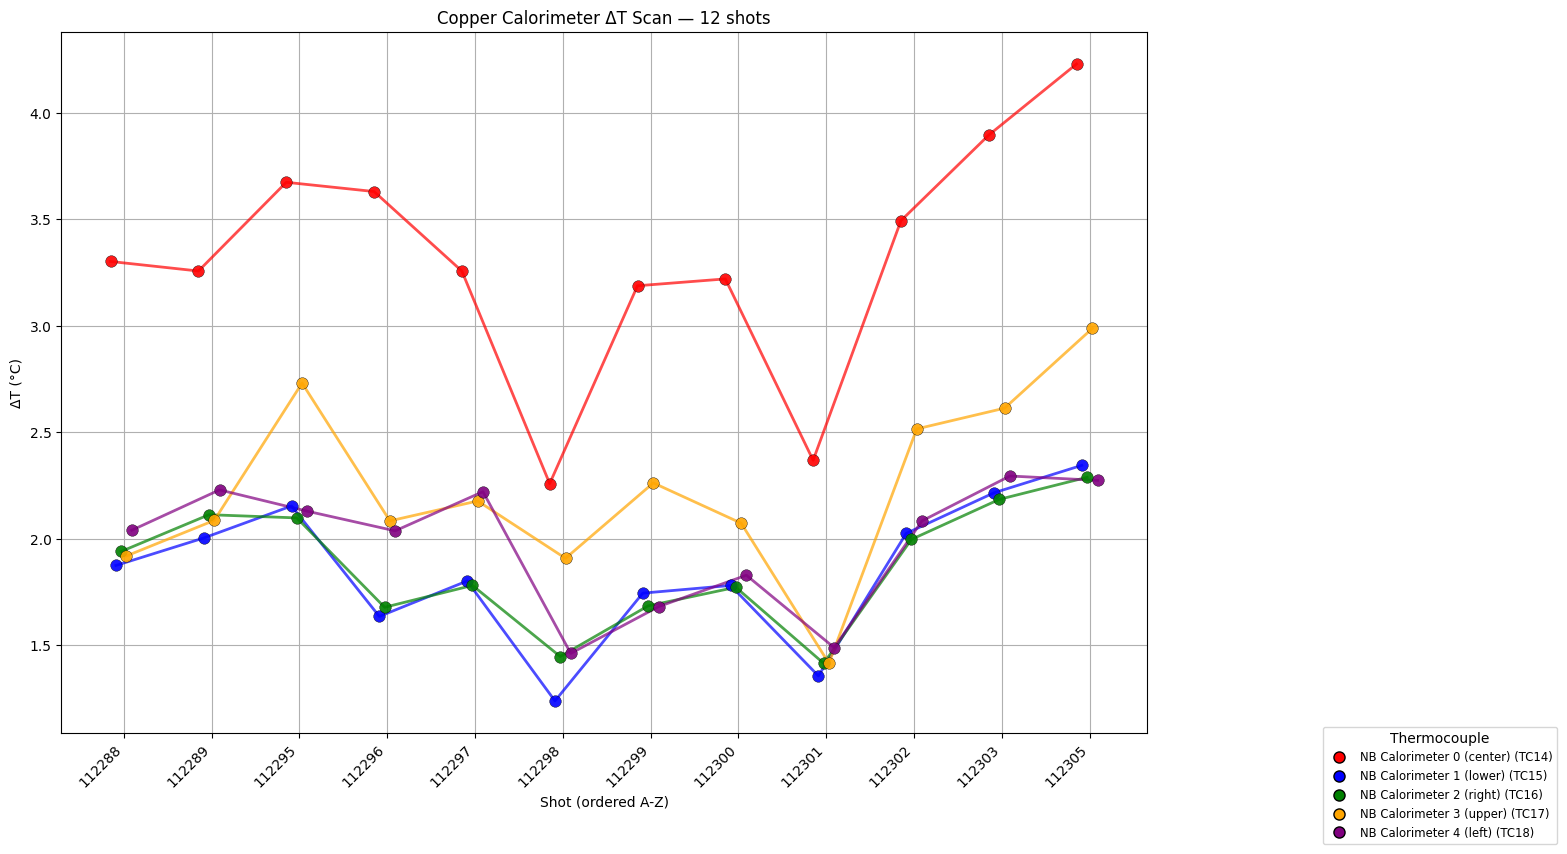


Scan plot created for 12 shots with 5 thermocouples


In [34]:
## Scan Plot - deltaT vs shot number

import re
from matplotlib.lines import Line2D

# using the deltaT_df from above
if deltaT_df.empty:
    print("No data to plot - deltaT_df is empty")
else:
    # need to sort shots properly (not just alphabetically)
    def natural_sort_key(text):
        """splits strings into text and number parts for proper sorting"""
        def tryint(s):
            try:
                return int(s)
            except ValueError:
                return s.lower()
        
        return [tryint(c) for c in re.split(r'(\d+)', text)]
    
    # sort the shots
    unique_files = list(deltaT_df['file'].unique())
    file_order = sorted(unique_files, key=natural_sort_key)
    
    print("Files will be ordered as:")
    for i, f in enumerate(file_order):
        print(f"  {i}: {f}")
    
    # map file names to x-axis indices
    file_to_idx = {f: i for i, f in enumerate(file_order)}
    
    # make the plot
    fig, ax = plt.subplots(figsize=(16, 9))
    
    ordered_tcs = ['TC14', 'TC15', 'TC16', 'TC17', 'TC18']
    
    for i, tc in enumerate(ordered_tcs):
        if tc not in deltaT_df.columns:
            continue
        
        color = TC_COLORS.get(tc, 'gray')
        label = TC_LABELS.get(tc, tc)
        
        # collect data points for this TC
        tc_data = []
        shot_indices = []
        
        for file in file_order:
            file_row = deltaT_df[deltaT_df['file'] == file]
            if not file_row.empty:
                deltaT_val = file_row[tc].values[0]
                if pd.notna(deltaT_val):
                    shot_idx = file_to_idx[file]
                    # offset slightly so points don't overlap
                    offset = (i - len(ordered_tcs)/2) * 0.06
                    shot_indices.append(shot_idx + offset)
                    tc_data.append(deltaT_val)
        
        if shot_indices:
            # draw lines connecting points
            ax.plot(shot_indices, tc_data, color=color, linewidth=2, alpha=0.7, linestyle='-')
            # scatter points on top
            ax.scatter(shot_indices, tc_data, s=70, alpha=0.9, c=color, marker='o', 
                      edgecolor='k', linewidth=0.3, zorder=5)
    
    # label x-axis with shot numbers
    ax.set_xticks(list(range(len(file_order))))
    ax.set_xticklabels(file_order, rotation=45, ha='right')
    ax.set_xlabel('Shot (ordered A-Z)')
    ax.set_ylabel('ΔT (°C)')
    ax.set_title(f'Copper Calorimeter ΔT Scan — {len(file_order)} shots')
    ax.grid(True)
    
    # make room for legend
    fig.tight_layout()
    fig.subplots_adjust(right=0.72, bottom=0.18)
    
    # legend for the TCs
    tc_handles = []
    for tc in ordered_tcs:
        lbl = TC_LABELS.get(tc, tc)
        col = TC_COLORS.get(tc, 'gray')
        tc_handles.append(Line2D([0], [0], marker='o', color='w', label=f"{lbl} ({tc})", 
                                 markerfacecolor=col, markersize=8, markeredgecolor='k'))
    
    fig.legend(handles=tc_handles, title='Thermocouple', loc='lower right', 
              bbox_to_anchor=(0.98, 0.05), bbox_transform=fig.transFigure, 
              fontsize='small', frameon=True)
    
    plt.show()
    
    print(f"\nScan plot created for {len(file_order)} shots with {len(ordered_tcs)} thermocouples")


In [35]:
## Get beam energy from MDSplus and normalize deltaT

import MDSplus as mds
import sys

# need Bill's helper functions for MDSplus access
sys.path.append('/u/hgajani/LTXb-py-main/LTXb-py-main/neutral_beam')
from bills_LTX_MDSplus_toolbox import get_tree_conn, get_data


def get_beam_energy(shot, v_thresh=5000.0):
    """Fetch total beam energy from MDSplus during beam-on period.
    
    Integrates power over time to get total energy in kJ
    """
    try:
        # figure out which tree to use
        if shot > 200000:
            treename = 'ltx_nbi'
            prefix = ''
        else:
            treename = 'ltx_b'
            prefix = '.oper_diags.ltx_nbi'
        
        tree = get_tree_conn(shot, treename=treename)
        (ti, ib) = get_data(tree, f'{prefix}.source_diags.i_hvps')
        (tv, vb) = get_data(tree, f'{prefix}.source_diags.v_hvps')
        
        # interpolate current onto voltage time base
        ib = np.interp(tv, ti, ib)
        pb = ib * vb / 1000.0  # kW
        
        # find beam-on period
        mask = vb > v_thresh
        if np.any(mask):
            # integrate power to get total energy
            tv_beam = tv[mask]
            pb_beam = pb[mask]
            total_energy = np.trapz(pb_beam, tv_beam)  # kJ (kW * s)
            return total_energy
        else:
            return np.nan
            
    except (mds.mdsExceptions.TreeNODATA, Exception) as e:
        print(f'Warning: Could not fetch beam power for shot {shot}: {e}')
        return np.nan


# fetch beam energy for all shots
print("Fetching beam energy from MDSplus...\n")

energy_data = []
for shot in shotlist:
    print(f"Processing shot {shot}...")
    energy_kJ = get_beam_energy(shot)
    energy_data.append({'shot': shot, 'beam_energy_kJ': energy_kJ})

# make dataframe
energy_df = pd.DataFrame(energy_data)
energy_df['file'] = energy_df['shot'].astype(str)

print("\n" + "="*80)
print("BEAM ENERGY DATA")
print("="*80)
print(energy_df.to_string(index=False))
print("="*80 + "\n")

# merge with deltaT data
merged_df = deltaT_df.merge(energy_df[['file', 'beam_energy_kJ']], on='file', how='left')

print("Merged DataFrame with beam energy:")
print(merged_df)

# normalize each TC by beam energy
# this gives units of °C/kJ (temp rise per kJ of beam energy)
normalized_df = merged_df.copy()

tc_columns = ['TC14', 'TC15', 'TC16', 'TC17', 'TC18']

for tc in tc_columns:
    norm_col = f'{tc}_norm'
    normalized_df[norm_col] = normalized_df[tc] / normalized_df['beam_energy_kJ']

print("\n" + "="*80)
print("NORMALIZED DELTA T BY BEAM ENERGY")
print("="*80)
print("\nNormalized values (°C/kJ):")

# show the results
display_cols = ['file', 'beam_energy_kJ'] + [f'{tc}_norm' for tc in tc_columns]
print(normalized_df[display_cols].to_string(index=False))

print("\n" + "="*80)

# Calculate mean normalized heating per shot (average across all TCs)
print("\n" + "="*80)
print("MEAN NORMALIZED HEATING PER SHOT")
print("="*80 + "\n")

mean_norm_heating = []
for idx, row in normalized_df.iterrows():
    shot_name = row['file']
    # get all normalized TC values for this shot
    norm_values = [row[f'{tc}_norm'] for tc in tc_columns if pd.notna(row[f'{tc}_norm'])]
    
    if norm_values:
        mean_norm = np.mean(norm_values)
        std_norm = np.std(norm_values)
        n_tcs = len(norm_values)
        mean_norm_heating.append({
            'Shot': shot_name,
            'Mean Norm ΔT (°C/kJ)': mean_norm,
            'Std Dev (°C/kJ)': std_norm,
            'N TCs': n_tcs
        })
    else:
        mean_norm_heating.append({
            'Shot': shot_name,
            'Mean Norm ΔT (°C/kJ)': np.nan,
            'Std Dev (°C/kJ)': np.nan,
            'N TCs': 0
        })

mean_norm_heating_df = pd.DataFrame(mean_norm_heating)
pd.set_option('display.float_format', lambda x: f"{x:.4f}" if pd.notna(x) else "nan")
print(mean_norm_heating_df.to_string(index=False))
print("\n" + "="*80)


Fetching beam energy from MDSplus...

Processing shot 112288...
Processing shot 112289...
Processing shot 112295...
Processing shot 112296...
Processing shot 112297...
Processing shot 112298...
Processing shot 112289...
Processing shot 112295...
Processing shot 112296...
Processing shot 112297...
Processing shot 112298...
Processing shot 112299...
Processing shot 112300...
Processing shot 112301...
Processing shot 112302...
Processing shot 112303...
Processing shot 112299...
Processing shot 112300...
Processing shot 112301...
Processing shot 112302...
Processing shot 112303...
Processing shot 112305...

BEAM ENERGY DATA
  shot  beam_energy_kJ   file
112288           2.569 112288
112289           2.778 112289
112295           2.608 112295
112296           2.608 112296
112297           2.640 112297
112298           2.032 112298
112299           2.585 112299
112300           2.574 112300
112301           1.913 112301
112302           2.872 112302
112303           2.912 112303
112305      

Files will be ordered as:
  0: 112288
  1: 112289
  2: 112295
  3: 112296
  4: 112297
  5: 112298
  6: 112299
  7: 112300
  8: 112301
  9: 112302
  10: 112303
  11: 112305


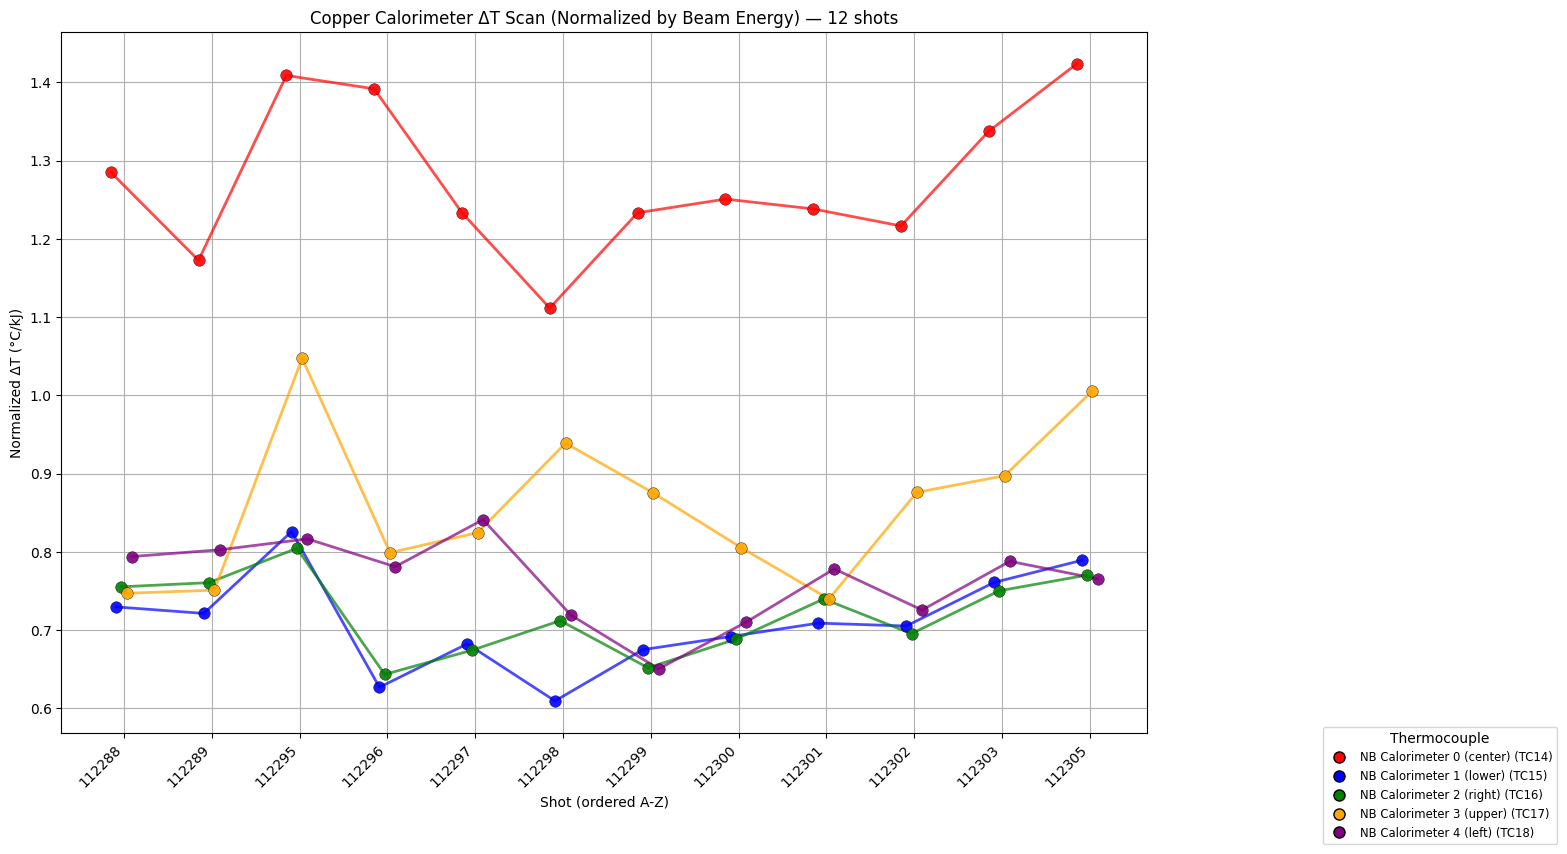


Normalized scan plot created for 12 shots with 5 thermocouples


In [36]:
## Scan plot with normalized deltaT (per beam energy)

import re
from matplotlib.lines import Line2D

# same plotting logic but with energy-normalized values
if normalized_df.empty:
    print("No data to plot - normalized_df is empty")
else:
    def natural_sort_key(text):
        """splits strings into text and number parts for proper sorting"""
        def tryint(s):
            try:
                return int(s)
            except ValueError:
                return s.lower()
        
        return [tryint(c) for c in re.split(r'(\d+)', text)]
    
    # sort shots
    unique_files = list(normalized_df['file'].unique())
    file_order = sorted(unique_files, key=natural_sort_key)
    
    print("Files will be ordered as:")
    for i, f in enumerate(file_order):
        print(f"  {i}: {f}")
    
    file_to_idx = {f: i for i, f in enumerate(file_order)}
    
    # make plot
    fig, ax = plt.subplots(figsize=(16, 9))
    
    ordered_tcs = ['TC14', 'TC15', 'TC16', 'TC17', 'TC18']
    
    for i, tc in enumerate(ordered_tcs):
        norm_col = f'{tc}_norm'
        if norm_col not in normalized_df.columns:
            continue
        
        color = TC_COLORS.get(tc, 'gray')
        label = TC_LABELS.get(tc, tc)
        
        # get normalized data for this TC
        tc_data = []
        shot_indices = []
        
        for file in file_order:
            file_row = normalized_df[normalized_df['file'] == file]
            if not file_row.empty:
                norm_val = file_row[norm_col].values[0]
                if pd.notna(norm_val):
                    shot_idx = file_to_idx[file]
                    # slight offset so points don't overlap
                    offset = (i - len(ordered_tcs)/2) * 0.06
                    shot_indices.append(shot_idx + offset)
                    tc_data.append(norm_val)
        
        if shot_indices:
            # plot lines and points
            ax.plot(shot_indices, tc_data, color=color, linewidth=2, alpha=0.7, linestyle='-')
            ax.scatter(shot_indices, tc_data, s=70, alpha=0.9, c=color, marker='o', 
                      edgecolor='k', linewidth=0.3, zorder=5)
    
    # x-axis labels
    ax.set_xticks(list(range(len(file_order))))
    ax.set_xticklabels(file_order, rotation=45, ha='right')
    ax.set_xlabel('Shot (ordered A-Z)')
    ax.set_ylabel('Normalized ΔT (°C/kJ)')
    ax.set_title(f'Copper Calorimeter ΔT Scan (Normalized by Beam Energy) — {len(file_order)} shots')
    ax.grid(True)
    
    # layout adjustments
    fig.tight_layout()
    fig.subplots_adjust(right=0.72, bottom=0.18)
    
    # legend
    tc_handles = []
    for tc in ordered_tcs:
        lbl = TC_LABELS.get(tc, tc)
        col = TC_COLORS.get(tc, 'gray')
        tc_handles.append(Line2D([0], [0], marker='o', color='w', label=f"{lbl} ({tc})", 
                                 markerfacecolor=col, markersize=8, markeredgecolor='k'))
    
    fig.legend(handles=tc_handles, title='Thermocouple', loc='lower right', 
              bbox_to_anchor=(0.98, 0.05), bbox_transform=fig.transFigure, 
              fontsize='small', frameon=True)
    
    plt.show()
    
    print(f"\nNormalized scan plot created for {len(file_order)} shots with {len(ordered_tcs)} thermocouples")
